# k-Nearest Neighbor (kNN) implementation

*Credits: this notebook is deeply based on Stanford CS231n course assignment 1. Source link: http://cs231n.github.io/assignments2019/assignment1/*

The kNN classifier consists of two stages:

- During training, the classifier takes the training data and simply remembers it
- During testing, kNN classifies every test image by comparing to all training images and transfering the labels of the k most similar training examples
- The value of k is cross-validated

In this exercise you will implement these steps and understand the basic Image Classification pipeline and gain proficiency in writing efficient, vectorized code.

We will work with the handwritten digits dataset. Images will be flattened (8x8 sized image -> 64 sized vector) and treated as vectors.

In [25]:
'''
If you are using Google Colab, uncomment the next line to download `k_nearest_neighbor.py`.
You can open and change it in Colab using the "Files" sidebar on the left.
'''
# !wget https://raw.githubusercontent.com/girafe-ai/ml-course/23s_dd_ml/homeworks/assignment0_01_knn/k_nearest_neighbor.py

'\nIf you are using Google Colab, uncomment the next line to download `k_nearest_neighbor.py`. \nYou can open and change it in Colab using the "Files" sidebar on the left.\n'

In [26]:
from sklearn import datasets
dataset = datasets.load_digits()
print(dataset.DESCR)

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

:Number of Instances: 1797
:Number of Attributes: 64
:Attribute Information: 8x8 image of integer pixels in the range 0..16.
:Missing Attribute Values: None
:Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
:Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each block. This generates
an in

In [27]:
# First 100 images will be used for testing. This dataset is not sorted by the labels, so it's ok
# to do the split this way.
# Please be careful when you split your data into train and test in general.
test_border = 100
X_train, y_train = dataset.data[test_border:], dataset.target[test_border:]
X_test, y_test = dataset.data[:test_border], dataset.target[:test_border]

print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
num_test = X_test.shape[0]

Training data shape:  (1697, 64)
Training labels shape:  (1697,)
Test data shape:  (100, 64)
Test labels shape:  (100,)


In [28]:
# Run some setup code for this notebook.
import random
import numpy as np
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (14.0, 12.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


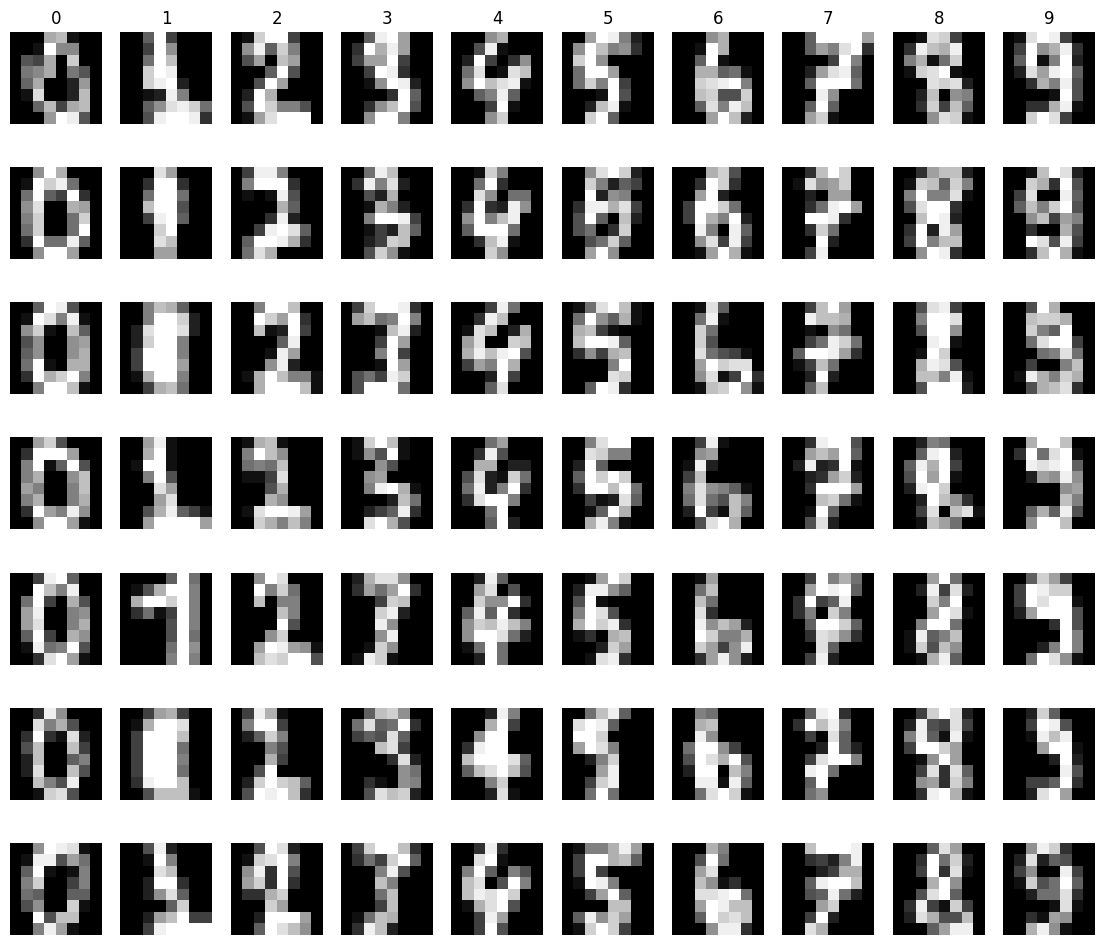

In [29]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = list(np.arange(10))
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].reshape((8, 8)).astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

Autoreload is a great stuff, but sometimes it does not work as intended. The code below aims to fix than. __Do not forget to save your changes in the `.py` file before reloading the `KNearestNeighbor` class.__

In [ ]:
# This dirty hack might help if the autoreload has failed for some reason
try:
    del KNearestNeighbor
except:
    pass

from k_nearest_neighbor import KNearestNeighbor

# Create a kNN classifier instance.
# Remember that training a kNN classifier is a noop:
# the Classifier simply remembers the data and does no further processing
classifier = KNearestNeighbor()
classifier.fit(X_train, y_train)

In [ ]:
X_train.shape

We would now like to classify the test data with the kNN classifier. Recall that we can break down this process into two steps:

1. First we must compute the distances between all test examples and all train examples.
2. Given these distances, for each test example we find the k nearest examples and have them vote for the label

Lets begin with computing the distance matrix between all training and test examples. For example, if there are **Ntr** training examples and **Nte** test examples, this stage should result in a **Nte x Ntr** matrix where each element (i,j) is the distance between the i-th test and j-th train example.

**Note: For the three distance computations that we require you to implement in this notebook, you may not use the np.linalg.norm() function that numpy provides.**

First, open `k_nearest_neighbor.py` and implement the function `compute_distances_two_loops` that uses a (very inefficient) double loop over all pairs of (test, train) examples and computes the distance matrix one element at a time.

In [ ]:
# Open k_nearest_neighbor.py and implement
# compute_distances_two_loops.

# Test your implementation:
dists = classifier.compute_distances_two_loops(X_test)
print(dists.shape)

In [ ]:
# We can visualize the distance matrix: each row is a single test example and
# its distances to training examples
plt.figure(figsize=(14, 5))  # Set the figure size
plt.imshow(dists, interpolation='none', aspect='auto')  # Specify aspect as 'auto'
plt.colorbar()  # Add a color bar
plt.show()

**Inline Question 1**

Notice the structured patterns in the distance matrix, where some rows or columns are visible brighter. (Note that with the default color scheme black indicates low distances while white indicates high distances.)

- What in the data is the cause behind the distinctly bright rows?
- What causes the columns?

$\color{blue}{\textit Your Answer:}$ *fill this in.*



In [ ]:
# Now implement the function predict_labels and run the code below:
# We use k = 1 (which is Nearest Neighbor).
y_test_pred = classifier.predict_labels(dists, k=1)

# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

You should expect to see approximately `95%` accuracy. Now lets try out a larger `k`, say `k = 5`:

In [ ]:
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Accuracy should slightly decrease with `k = 5` compared to `k = 1`.

**Inline Question 2**

We can also use other distance metrics such as L1 distance.
For pixel values $p_{ij}^{(k)}$ at location $(i,j)$ of some image $I_k$,

the mean $\mu$ across all pixels over all images is $$\mu=\frac{1}{nhw}\sum_{k=1}^n\sum_{i=1}^{h}\sum_{j=1}^{w}p_{ij}^{(k)}$$
And the pixel-wise mean $\mu_{ij}$ across all images is
$$\mu_{ij}=\frac{1}{n}\sum_{k=1}^np_{ij}^{(k)}.$$
The general standard deviation $\sigma$ and pixel-wise standard deviation $\sigma_{ij}$ is defined similarly.

Which of the following preprocessing steps will not change the performance of a Nearest Neighbor classifier that uses L1 distance? Select all that apply.
1. Subtracting the mean $\mu$ ($\tilde{p}_{ij}^{(k)}=p_{ij}^{(k)}-\mu$.)
2. Subtracting the per pixel mean $\mu_{ij}$  ($\tilde{p}_{ij}^{(k)}=p_{ij}^{(k)}-\mu_{ij}$.)
3. Subtracting the mean $\mu$ and dividing by the standard deviation $\sigma$.
4. Subtracting the pixel-wise mean $\mu_{ij}$ and dividing by the pixel-wise standard deviation $\sigma_{ij}$.
5. Rotating the coordinate axes of the data.

$\color{blue}{\textit Your Answer:}$


$\color{blue}{\textit Your Explanation:}$


In [ ]:
# Now lets speed up distance matrix computation by using partial vectorization
# with one loop. Implement the function compute_distances_one_loop and run the
# code below:
dists_one = classifier.compute_distances_one_loop(X_test)

# To ensure that our vectorized implementation is correct, we make sure that it
# agrees with the naive implementation. There are many ways to decide whether
# two matrices are similar; one of the simplest is the Frobenius norm. In case
# you haven't seen it before, the Frobenius norm of two matrices is the square
# root of the squared sum of differences of all elements; in other words, reshape
# the matrices into vectors and compute the Euclidean distance between them.
difference = np.linalg.norm(dists - dists_one, ord='fro')
print('One loop difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

In [ ]:
# Now implement the fully vectorized version inside compute_distances_no_loops
# and run the code
dists_two = classifier.compute_distances_no_loops(X_test)

# check that the distance matrix agrees with the one we computed before:
difference = np.linalg.norm(dists - dists_two, ord='fro')
print('No loop difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

### Comparing handcrafted and `sklearn` implementations
In this section we will just compare the performance of handcrafted and `sklearn` kNN algorithms. The predictions should be the same. No need to write any code in this section.

In [ ]:
from sklearn import neighbors

In [ ]:
implemented_knn = KNearestNeighbor()
implemented_knn.fit(X_train, y_train)

In [ ]:
n_neighbors = 1
external_knn = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors)
external_knn.fit(X_train, y_train)
print('sklearn kNN (k=1) implementation achieves: {} accuracy on the test set'.format(
    external_knn.score(X_test, y_test)
))
y_predicted = implemented_knn.predict(X_test, k=n_neighbors).astype(int)
accuracy_score = sum((y_predicted==y_test).astype(float)) / num_test
print('Handcrafted kNN (k=1) implementation achieves: {} accuracy on the test set'.format(accuracy_score))
assert np.array_equal(
    external_knn.predict(X_test),
    y_predicted
), 'Labels predicted by handcrafted and sklearn kNN implementations are different!'
print('\nsklearn and handcrafted kNN implementations provide same predictions')
print('_'*76)


n_neighbors = 5
external_knn = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors)
external_knn.fit(X_train, y_train)
print('sklearn kNN (k=5) implementation achieves: {} accuracy on the test set'.format(
    external_knn.score(X_test, y_test)
))
y_predicted = implemented_knn.predict(X_test, k=n_neighbors).astype(int)
accuracy_score = sum((y_predicted==y_test).astype(float)) / num_test
print('Handcrafted kNN (k=5) implementation achieves: {} accuracy on the test set'.format(accuracy_score))
assert np.array_equal(
    external_knn.predict(X_test),
    y_predicted
), 'Labels predicted by handcrafted and sklearn kNN implementations are different!'
print('\nsklearn and handcrafted kNN implementations provide same predictions')
print('_'*76)



### Measuring the time
Finally let's compare how fast the implementations are.

To make the difference more noticable, let's repeat the train and test objects (there is no point but to compute the distance between more pairs).

In [ ]:
X_train_big = np.vstack([X_train]*5)
X_test_big = np.vstack([X_test]*5)
y_train_big = np.hstack([y_train]*5)
y_test_big = np.hstack([y_test]*5)

In [ ]:
classifier_big = KNearestNeighbor()
classifier_big.fit(X_train_big, y_train_big)
# Let's compare how fast the implementations are
def time_function(f, *args):
    """
    Call a function f with args and return the time (in seconds) that it took to execute.
    """
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

two_loop_time = time_function(classifier_big.compute_distances_two_loops, X_test_big)
print('Two loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(classifier_big.compute_distances_one_loop, X_test_big)
print('One loop version took %f seconds' % one_loop_time)

no_loop_time = time_function(classifier_big.compute_distances_no_loops, X_test_big)
print('No loop version took %f seconds' % no_loop_time)

# You should see significantly faster performance with the fully vectorized implementation!

# NOTE: depending on what machine you're using,
# you might not see a speedup when you go from two loops to one loop,
# and might even see a slow-down.

The improvement seems significant. (On some hardware one loop version may take even more time, than two loop, but no loop should definitely be the fastest.

**Inline Question 3**

Which of the following statements about $k$-Nearest Neighbor ($k$-NN) are true in a classification setting, and for all $k$? Select all that apply.
1. The decision boundary (hyperplane between classes in feature space) of the k-NN classifier is linear.
2. The training error of a 1-NN will always be lower than that of 5-NN.
3. The test error of a 1-NN will always be lower than that of a 5-NN.
4. The time needed to classify a test example with the k-NN classifier grows with the size of the training set.
5. None of the above.

$\color{blue}{\textit Your Answer:}$


$\color{blue}{\textit Your Explanation:}$



Congratulations! Please, submit the .py file to the contest system.